<h1>Прогнозирование температуры звезды<a class="tocSkip"></h1>
   
<h2>Краткое описание<a class="tocSkip"></h2>

Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.
    
<h2>Цель проекта<a class="tocSkip"></h2>
    
С помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:
- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

Необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.
    
<h2>Описание данных<a class="tocSkip"></h2> 
  
    
- `L/Lo` Относительная светимость  — светимость звезды относительно Солнца.
- `R/RoО` тносительный радиус  — радиус звезды относительно радиуса Солнца.
- `Mv` Абсолютная звёздная величина  — физическая величина, характеризующая блеск звезды.
- `Звёздный цвет (white, red, blue, yellow, yellow-orange и др.)` — цвет звезды, который определяют на основе спектрального анализа.
- Тип звезды.  
- `T(K)` Абсолютная температура  — температура на поверхности звезды в Кельвинах.

In [1]:
!pip install missingno -q
!pip install sweetviz -q
!pip install phik -q

In [2]:
#импортируем используемые библиотеки
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots

# Работа с пропусками
import missingno as msno

import warnings  # Управление предупреждениями
warnings.filterwarnings("ignore") 

import tqdm as notebook_tqdm # Новые шкалы прогресса


#библиотека для расчета коэффициентов корреляции Фи
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

#EDA
import sweetviz as sv

# кодировщики
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler,
    LabelEncoder
)

#создание выборок
from sklearn.model_selection import train_test_split

#создание нейросетей
import torch 
import torch.nn as nn

#математические вычисления
import math

#даталоадер для ускорения обучения
from torch.utils.data import DataLoader, TensorDataset

import random

In [3]:
#Константы
RANDOM_STATE = SEED = 42
TEST_SIZE = 0.3

<h2><b>Оглавление</b><a class="tocSkip"></h2>

<a href='#Step0'><b>Функции, используемые в проекте</b></a>   
    
<a href='#Step1'><b>1. Загрузка данных</b></a>
    
<a href='#Step2'><b>2. Предобработка и анализ данных</b></a>
- <a href='#Step2.1'><b>2.1 Предобработка данных</b></a>
- <a href='#Step2.2'><b>2.2 Анализ данных</b></a>
- <a href='#Step2.3'><b>2.3 Вывод по разделу</b></a>

<a href='#Step3'><b>3. Построение базовой нейронной сети</b></a>   

<a href='#Step4'><b>4. Улучшение нейронной сети</b></a>   
    
<a href='#Step5'><b>5. Итоговый вывод</b></a> 

<a id='Step0'></a>
<h3><b> Функции, используемые в проекте<a class="tocSkip"></h3>

In [4]:
#Функция для отображения основной информации по датафрейму

def check_df (dataframes):
    for df in dataframes:
        df_name = [name for name, obj in globals().items() if obj is df][0]
        print(f'Общая информация по датафрейму {df_name}:')
        # общая информация
        df.info()
        # первые 5 строк
        display(df.head())
        print()

<a id='Step1'></a>
## 1. Загрузка данных

In [5]:
df = pd.read_csv('/datasets/6_class.csv')

In [6]:
check_df([df])

Общая информация по датафрейму df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


<a id='Step2'></a>
## 2. Предобработка и анализ данных

<a id='Step2.1'></a>
### 2.1 Предобработка данных

Пропущенные значения в тренировочном наборе данных
Series([], dtype: int64)


Визуализация пропусков


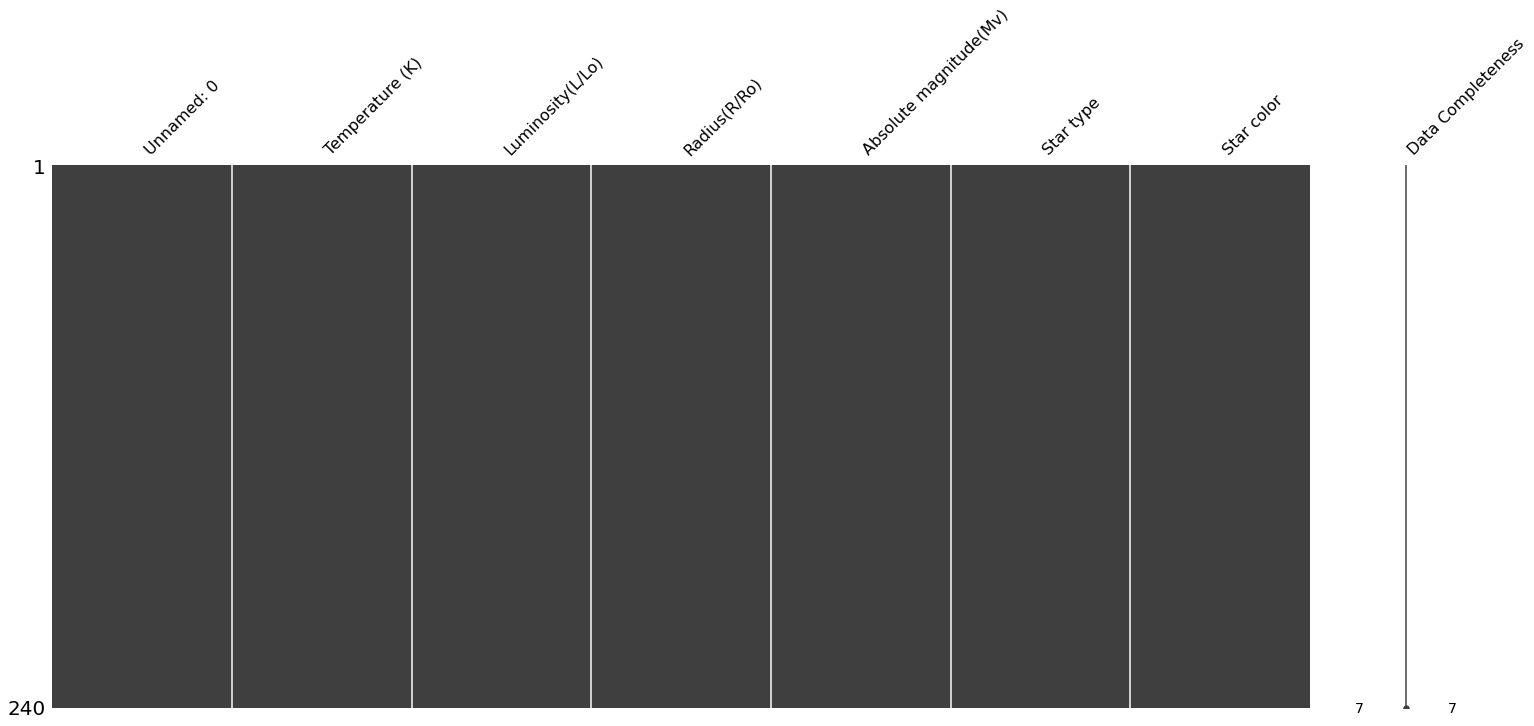

In [7]:
# Проверка на пропуски в тренировочном наборе данных
print('Пропущенные значения в тренировочном наборе данных')
missing_train = df.isnull().sum()
print(missing_train[missing_train > 0])
print("\n")
print('Визуализация пропусков')
msno.matrix(df, labels=True)
plt.show()

In [8]:
df.describe()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,119.50000,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,69.42622,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,0.00000,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,59.75000,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,119.50000,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,179.25000,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,239.00000,40000.000000,849420.000000,1948.500000,20.060000,5.000000


1. В датафрейме 240 звезд разных типов и имеют разные характеристики.
2. Пропущенных значений нет.
3. Относительная светимость и Относительный радиус могут иметь значения близкие к нулю.
4. Абсолютная звёздная величина может быть отрицательной

Столбец `Unnamed: 0` не несет важную информацию, представляет собой порядковый номер звезды, начиная с `0`. Его уберем из датафрейма

In [9]:
df_final = df.drop(columns=['Unnamed: 0'])
df_final.tail()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
235,38940,374830.0,1356.0,-9.93,5,Blue
236,30839,834042.0,1194.0,-10.63,5,Blue
237,8829,537493.0,1423.0,-10.73,5,White
238,9235,404940.0,1112.0,-11.23,5,White
239,37882,294903.0,1783.0,-7.80,5,Blue


In [10]:
df_final.columns = ['temperature', 'luminosity', 'radius', 'absolute_magnitude', 'star_type', 'star_color']

In [11]:
df_final

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue
236,30839,834042.000000,1194.0000,-10.63,5,Blue
237,8829,537493.000000,1423.0000,-10.73,5,White
238,9235,404940.000000,1112.0000,-11.23,5,White


In [12]:
df_final['star_color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

**Цвета нужно переименовать, так как дублируются одинаковые значения в разном написании**

- `Blue White` и `Blue-white`, `Blue white `, `Blue-White`
- `Blue` и `Blue `

In [13]:
df_final['star_color'] = df_final['star_color'].str.lower()

In [14]:
bluewhitelist = ['blue-white', 'blue white', 'blue-White', 'blue white ']
yellow = ['yellowish white', 'yellow-white', 'white-yellow', 'yellowish']
orange = ['pale yellow orange', 'orange-red']
for i in bluewhitelist:
    df_final['star_color'] = df_final['star_color'].str.strip().replace({i: 'blue white'})
for i in yellow:
    df_final['star_color'] = df_final['star_color'].str.strip().replace({i: 'yellow white'})
for i in orange:
    df_final['star_color'] = df_final['star_color'].str.strip().replace({i: 'orange'})
df_final['star_color'] = df_final['star_color'].str.strip().replace({'whitish': 'white'})

In [15]:
df_final['star_color'].unique()

array(['red', 'blue white', 'white', 'yellow white', 'orange', 'blue'],
      dtype=object)

<a id='Step2.2'></a>
### 2.2 Анализ данных (EDA)

In [16]:
report = sv.analyze([df_final, " Permit Logs"])

                                             |          | [  0%]   00:00 -> (? left)


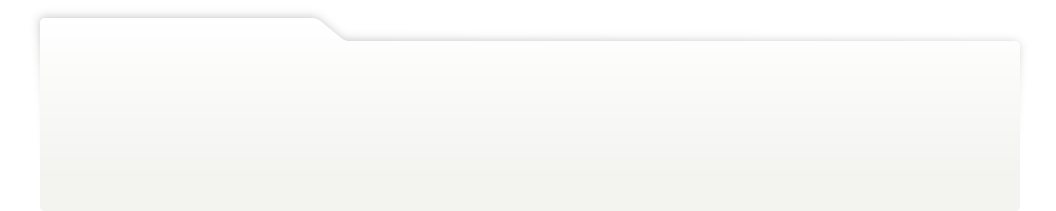
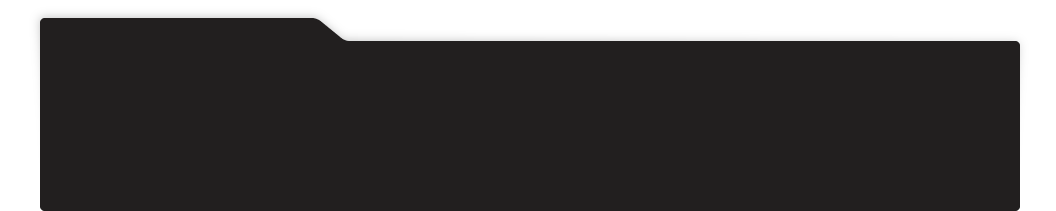
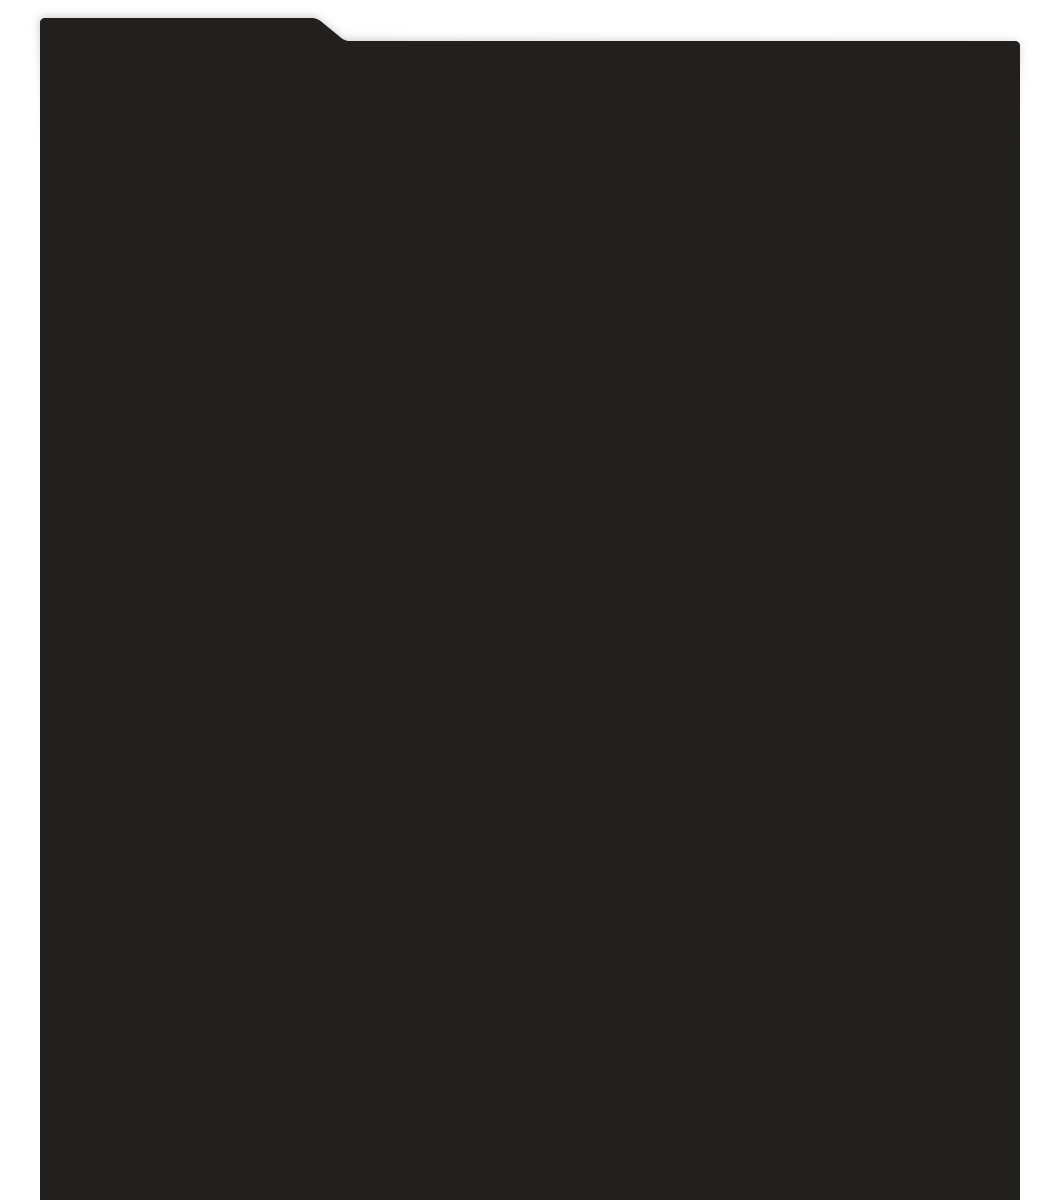
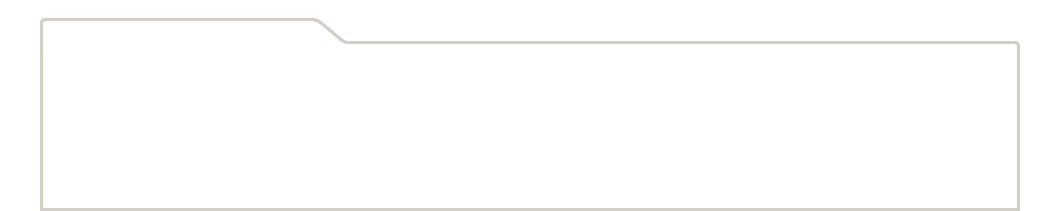
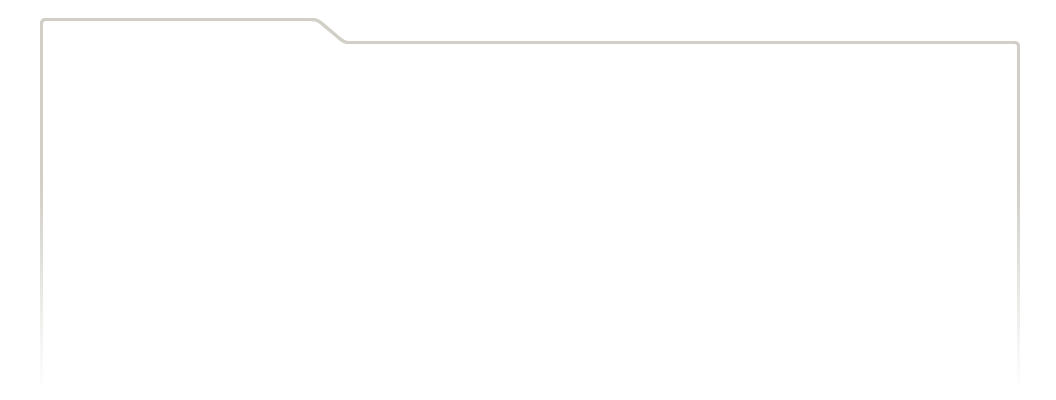
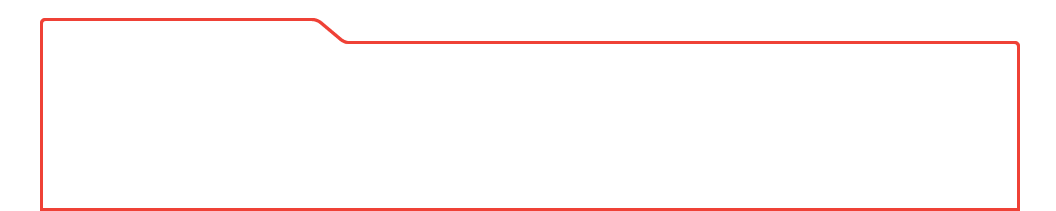
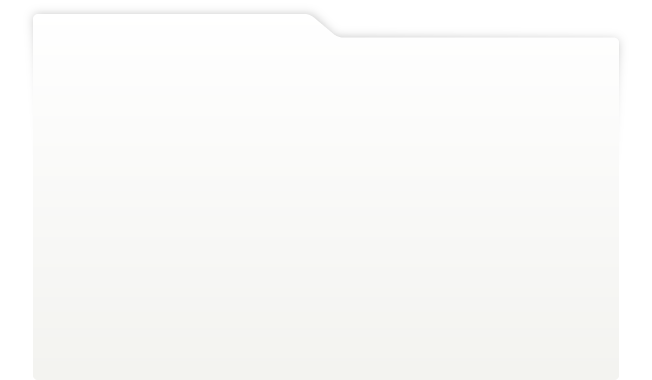
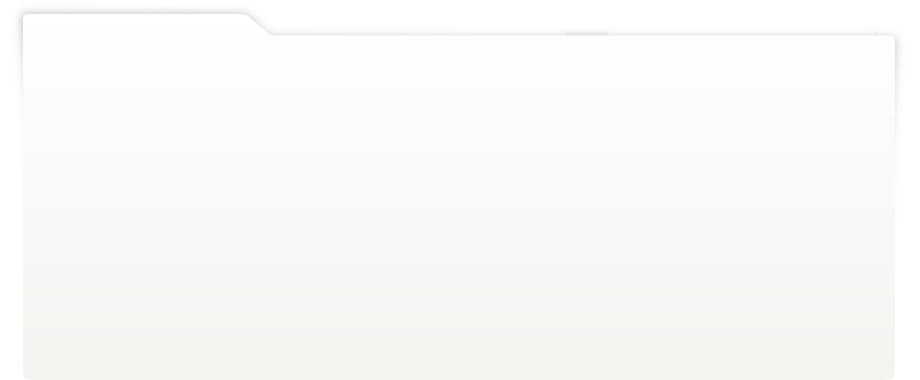
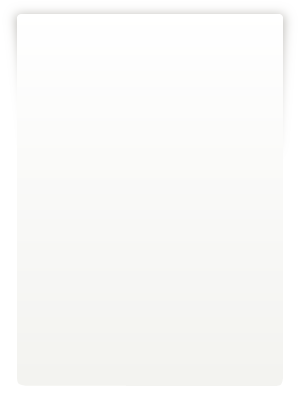
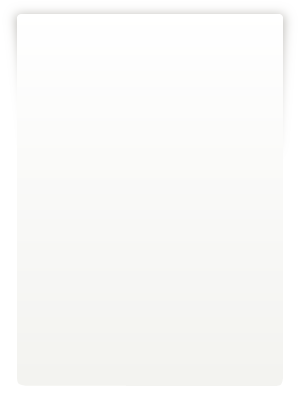
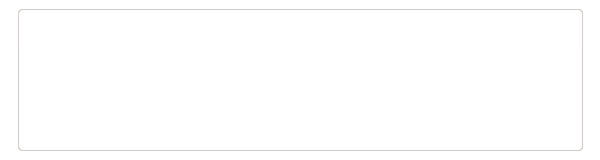
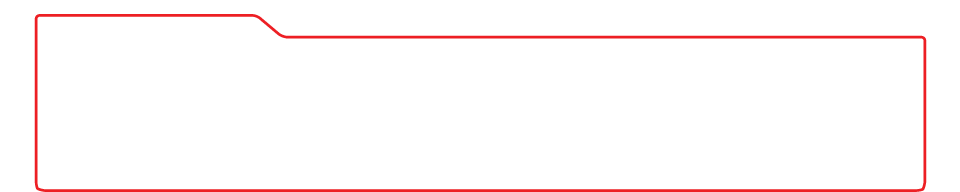
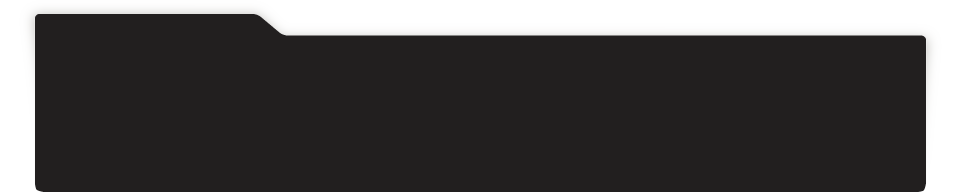
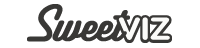
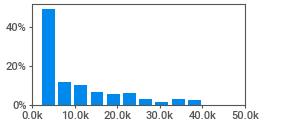
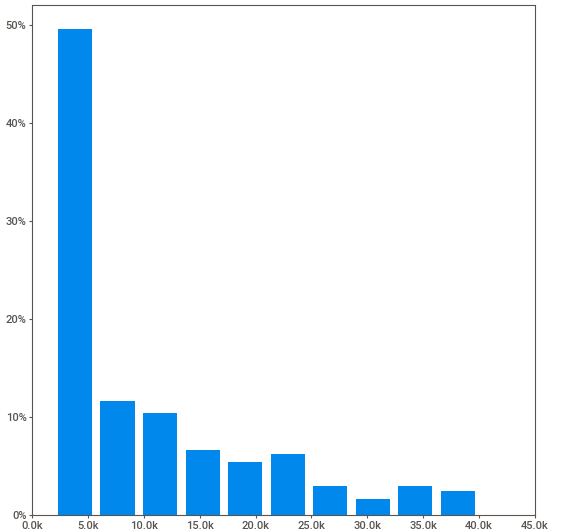
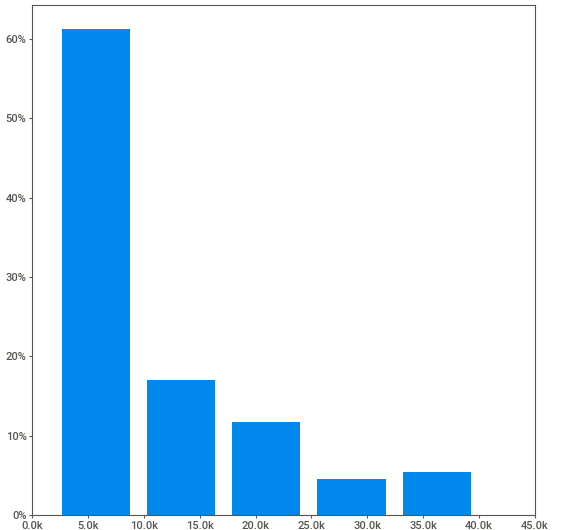
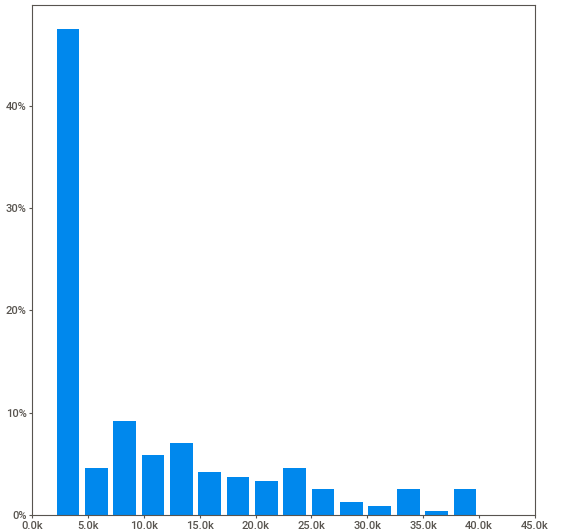
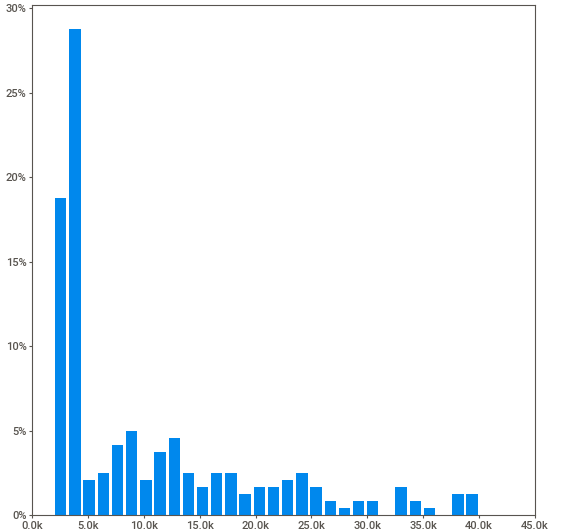
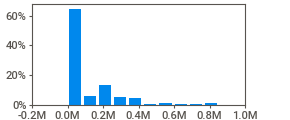
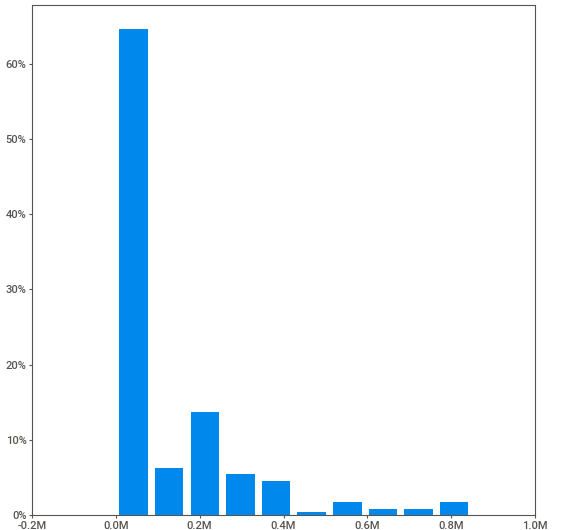
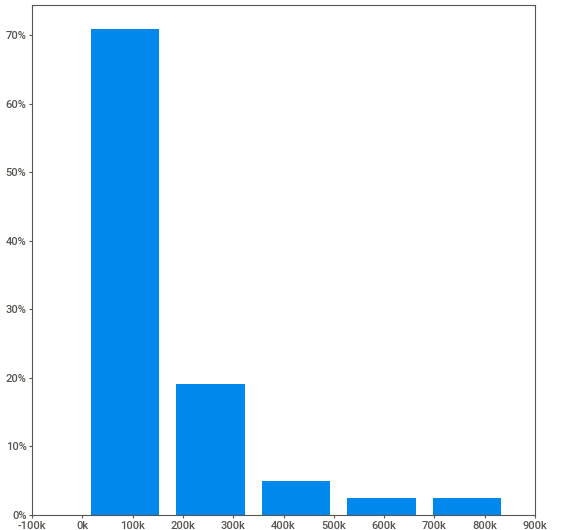
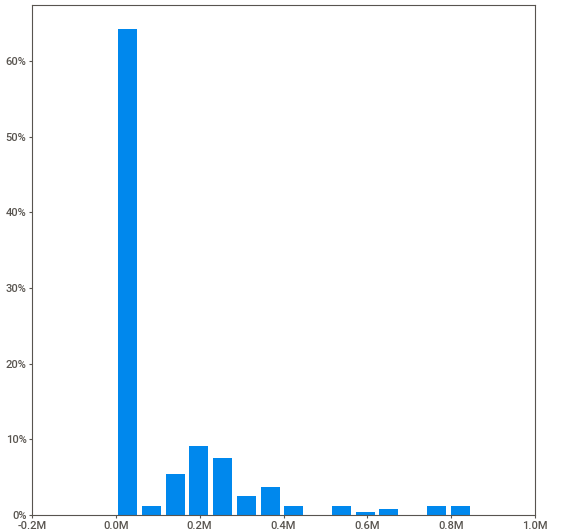
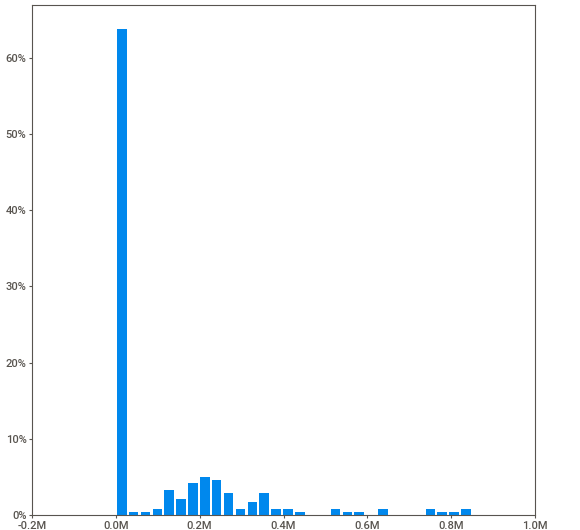
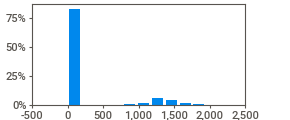
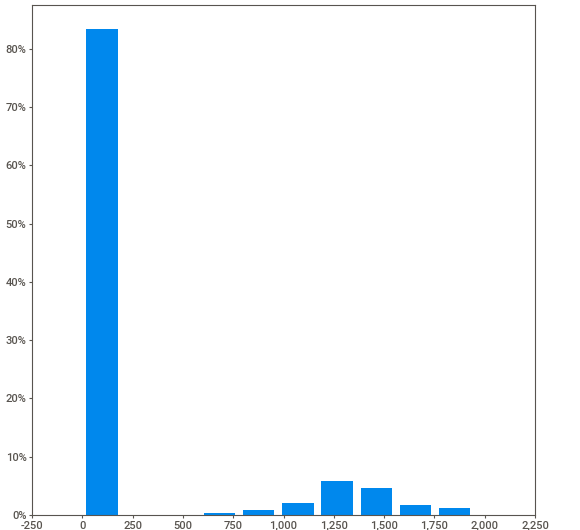
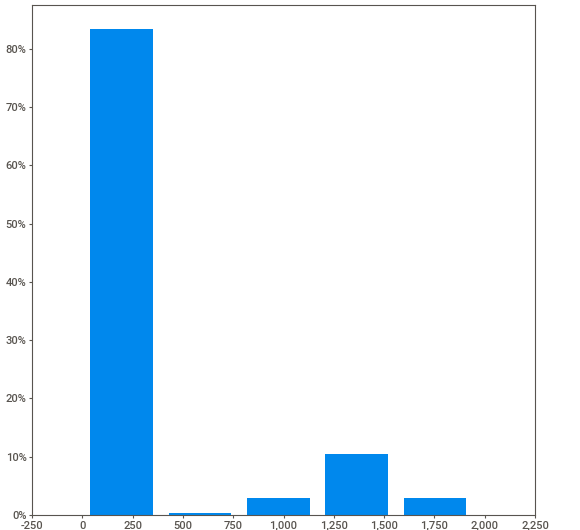
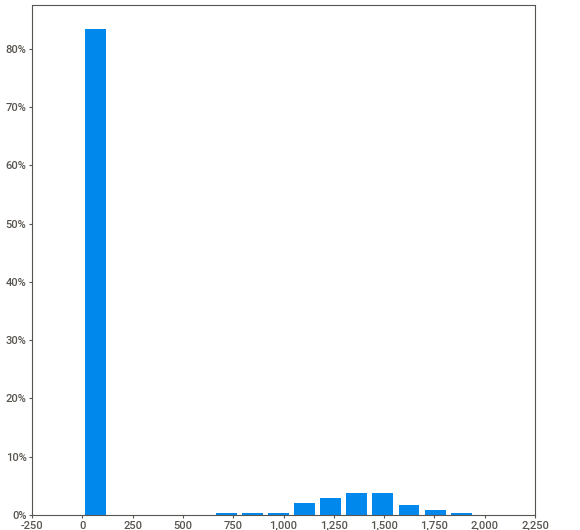
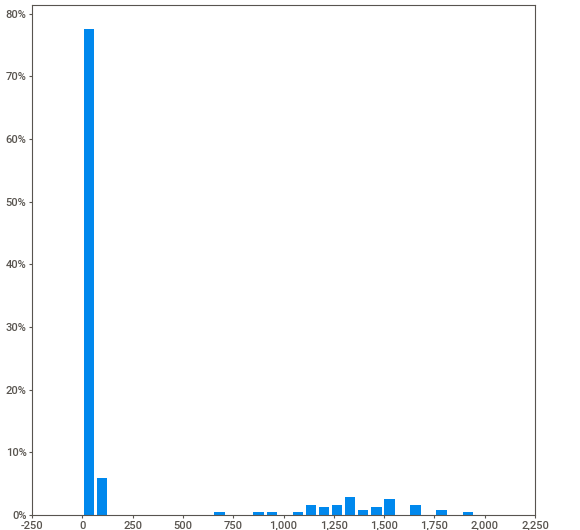
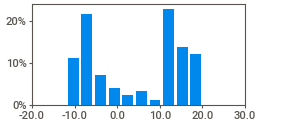
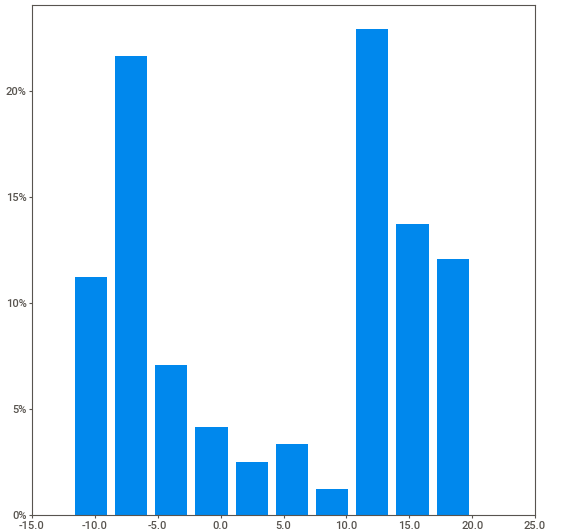
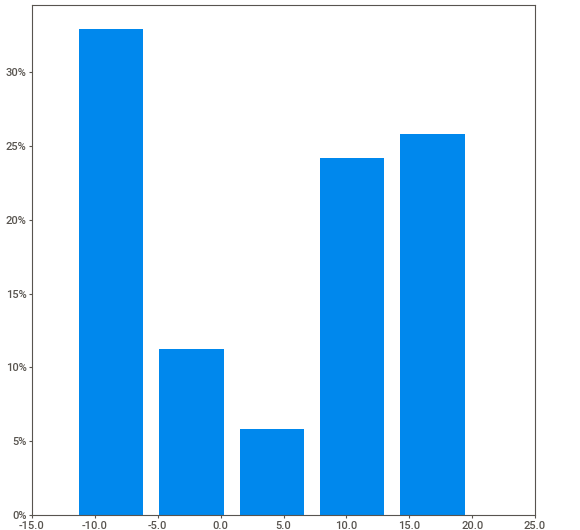
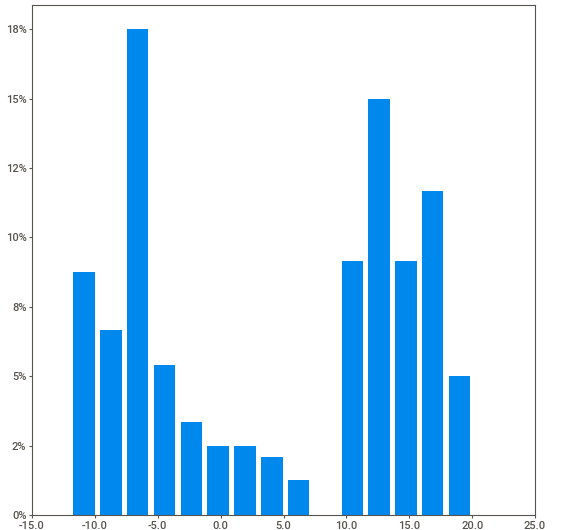
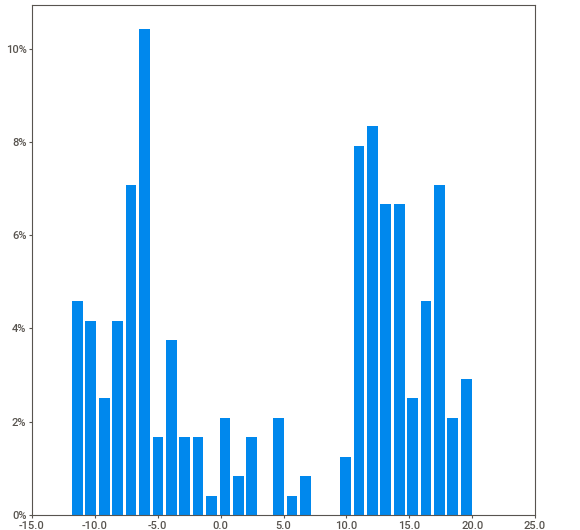
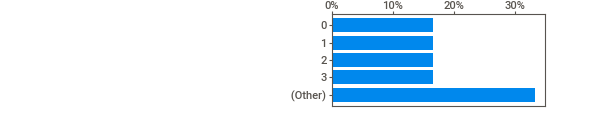
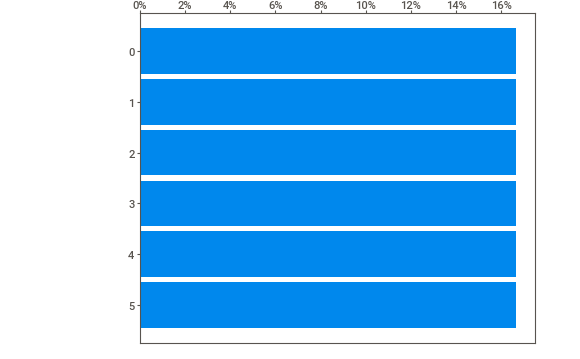
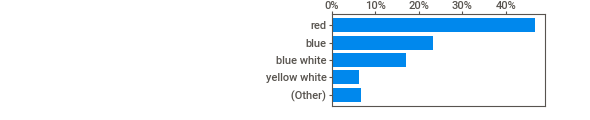
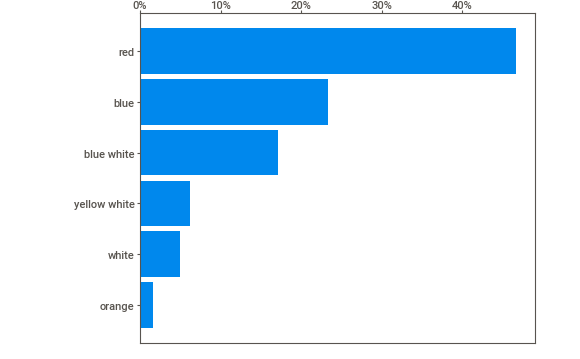
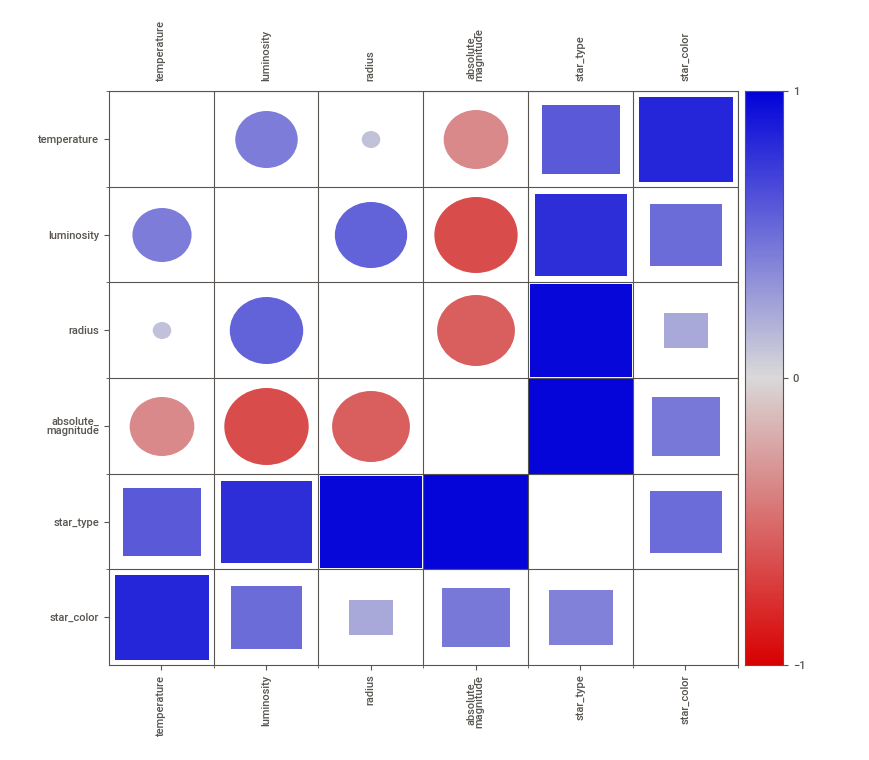
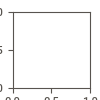

In [17]:
report.show_notebook()

**Диаграммы рассеяния целевого признака `temperature` от входным признаков с зависимости от типа звезд**

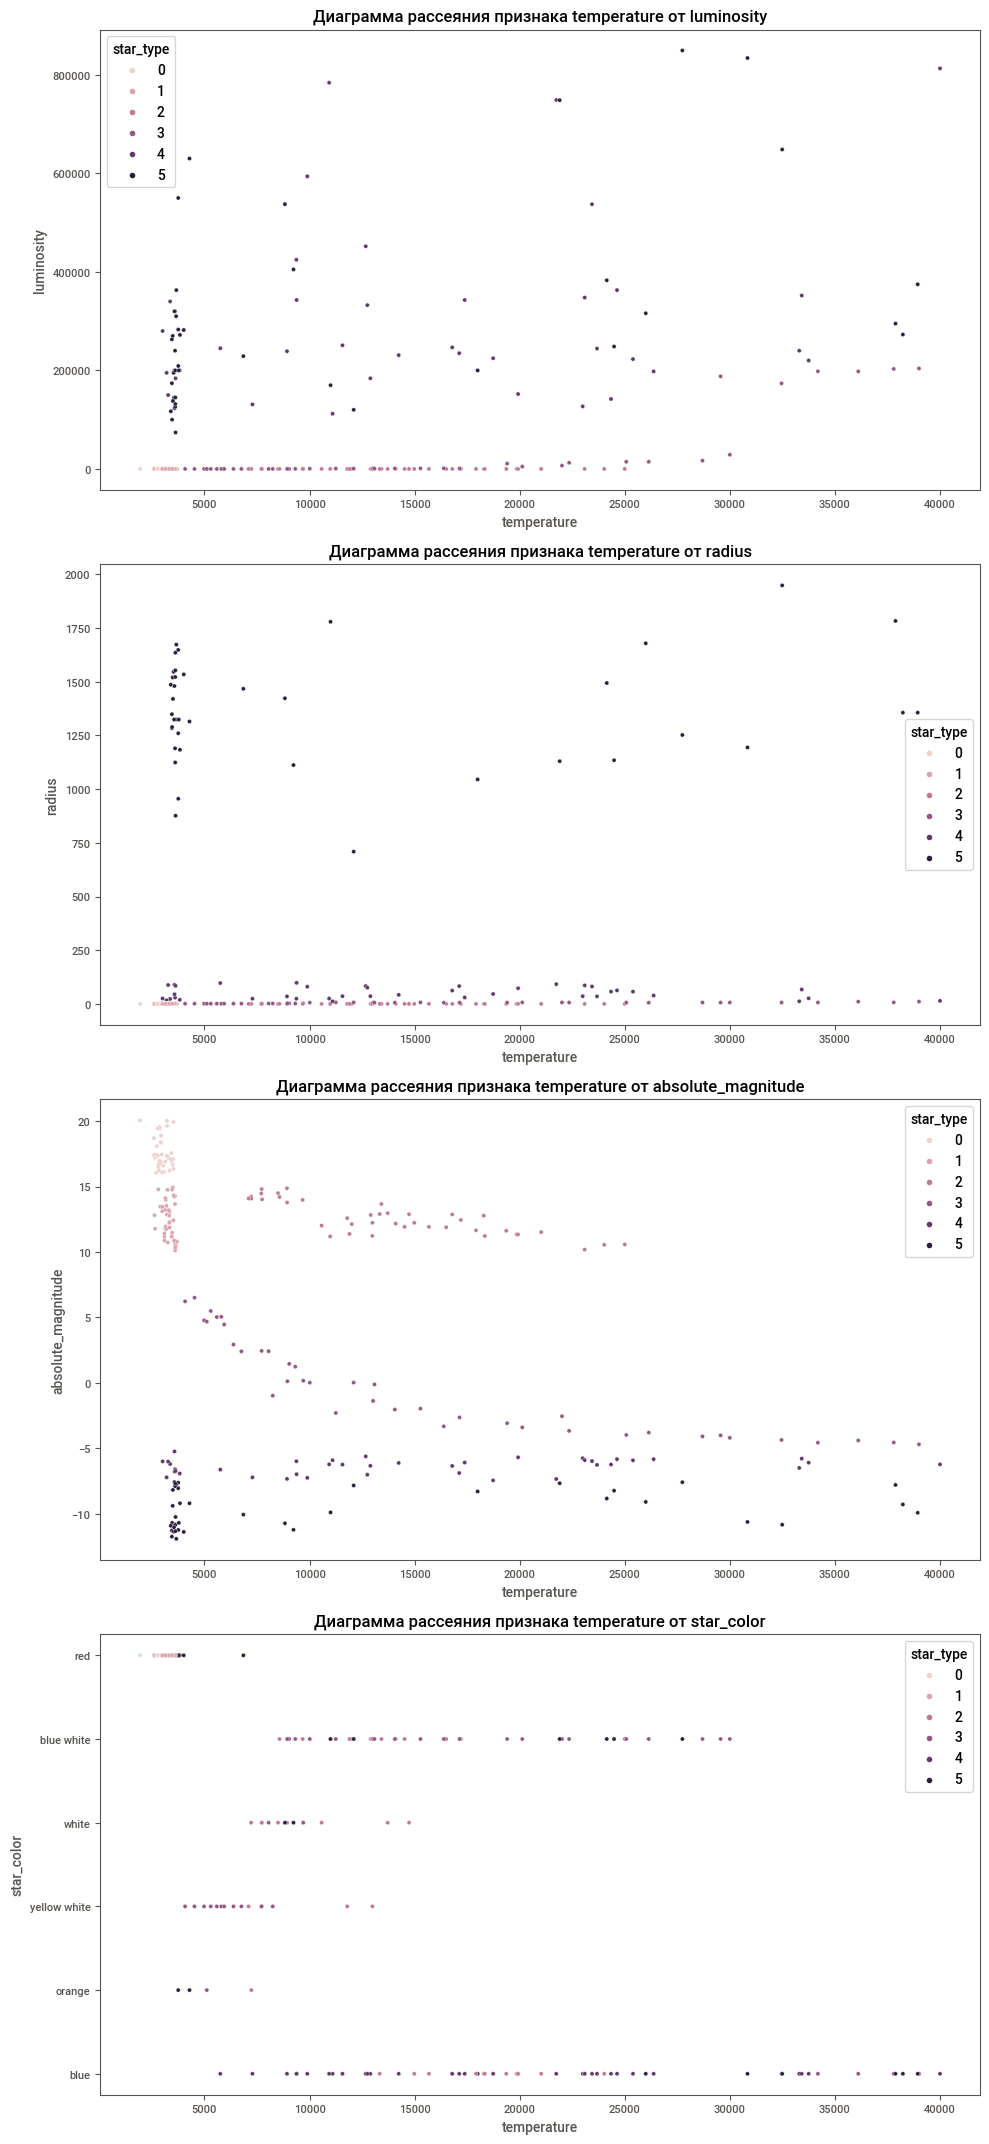

In [18]:
num_columns = ['luminosity', 'radius', 'absolute_magnitude', 'star_color']
cat_columns = ['star_color']

plt.figure(figsize=(10, 80))

for i,num_col in enumerate(num_columns):
    for j, cat_col in enumerate(cat_columns):
        if i < len(num_columns) and j < len(cat_columns):
            plt.subplot(15, 1, i * len(cat_columns) + j + 1)
            sns.scatterplot(data=df_final, x='temperature' , y=num_col, hue='star_type')
            plt.title(f'Диаграмма рассеяния признака temperature от {num_col}')

plt.tight_layout()
plt.show()

**Построение матрицы корреляции для признаков**

In [19]:
interval_cols = ['temperature', 'luminosity', 
                 'radius', 'absolute_magnitude']

In [20]:
f_corr_matr = df_final.phik_matrix(interval_cols=interval_cols)
f_corr_matr

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
temperature,1.000000,0.562667,0.236637,0.710472,0.603924,0.738184
luminosity,0.562667,1.000000,0.574964,0.709456,0.654026,0.471721
radius,0.236637,0.574964,1.000000,0.512414,0.635115,0.168823
absolute_magnitude,0.710472,0.709456,0.512414,1.000000,0.915921,0.699401
star_type,0.603924,0.654026,0.635115,0.915921,1.000000,0.853708
star_color,0.738184,0.471721,0.168823,0.699401,0.853708,1.000000


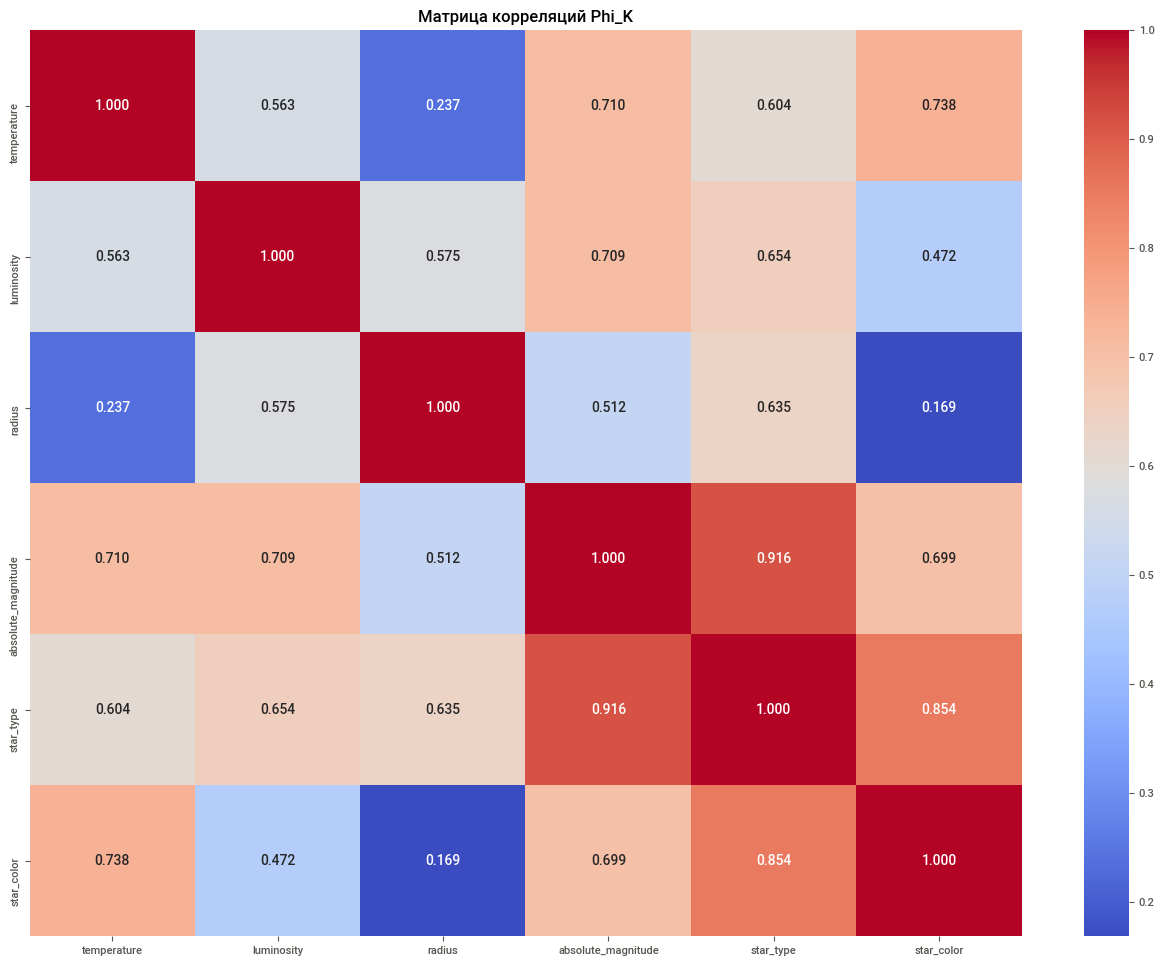

In [21]:
#Построение тепловой карты методом sns.heatmap()
plt.figure(figsize=(16, 12))
sns.heatmap(f_corr_matr, annot=True, cmap='coolwarm', fmt='.3f')
#plt.xticks(rotation=45)
plt.title('Матрица корреляций Phi_K')
plt.show()

<a id='Step2.3'></a>
### 2.3 Вывод по разделу

**Количественные данные**
- Temperature (K), Luminosity(L/Lo), Radius(R/Ro), Absolute magnitude(Mv)
1. Temperature (K) - Абсолютная температура
    - Распределение ненормальное. Основное количество звезд имеют температуру `5 тысяч Кельвинов`
    - Самые горячие звезды - `40000 К` - 0,4% от общей массы данных
    - Самые холодные звезды - `2840 К` - 0,4% от общей массы данных
    - В среднем звезды имеют температуру `10497 К` и медиана `5776 К`
2. Luminosity(L/Lo) - Относительная светимость
    - Распределение ненормальное. Основное количество звезд имеют относительную светимость `107000`
    - Самые яркие - `849000`
    - Самые темные имеют близкое значение к 0
3. Radius(R/Ro) - Относительный радиус
    - Если не учитывает наиболее встречаемые значения в районе `237`, то распределение выглядит нормальным
    - В осноном относительный радиус звезд около `237` и медиана `1`
    - Самые большие имеют относительный радиус `1948` и самые маленькие близятся к 0
4. Absolute magnitude(Mv) - Абсолютная звёздная величина
    - Ненормальное распределение с двумя пиками в районе `-10` и `16`
    - Самую высокую действительную светимость имеют звезды со значением `20.1` и самую низкую `-11.9`
    - Медиана `8.3` и среднее `4.4`
    
**Категориальные данные**
- Star type, Star color
1. Star type - Тип звезды
    - Всего `6 типов` звезд
    - Все типы одинаково распределены между собой `по 17% - по 40` звезд каждого типа
2. Star color - Цвет звезды
    - В представленном датасете 19 цветов звезд
    - Наиболее часто встречаемые звезды `Red` - `112 штук 47%`, `Blue` - 23% и `Blue-white` - `17%`
    
    
**Корреляционный анализ**

- `Temperature (K)` имеют сильную корреляцуию с `Star type и Star color - 0.57 и 0.83` соответственно. Логично, что температура звезды напрямую влияет на ее цвет и тип.
- `Luminosity(L/Lo)` коррелирует с `Star type и Star color` слабее, чем температура, но также высокая `0.53 и 0.79` соответственно.
- Radius(R/Ro) очень сильно зависит от `Star type`. Класс звезды ведь присваиют в зависимости от ее характеристик - размеров и температуры - `0.98`
- Absolute magnitude(Mv) - также очень сильно коррелирует с `Star type` - `0.98`

**Категоризируем исходные данные**

Преобразуем при помощи OneHotEncoder столбец с цветами звезд, потому что датасет маленького размера (менее 10000 строк), цветов не так много (14 видов). Сохраняет информацию о каждом цвете без искажений. 

In [22]:
df_final_enc = df_final.copy()
df_final_enc.head()

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
0,3068,0.002400,0.1700,16.12,0,red
1,3042,0.000500,0.1542,16.60,0,red
2,2600,0.000300,0.1020,18.70,0,red
3,2800,0.000200,0.1600,16.65,0,red
4,1939,0.000138,0.1030,20.06,0,red


**Подготовим обучающую и тестовую выборки**

In [23]:
ohe_columns = ['star_color']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    df_final_enc.drop(columns=['temperature']), 
    df_final_enc['temperature'], 
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_final_enc['star_color'],  # ← исправлено
    shuffle=True
)

**Закодируем категориальный признак**

In [25]:
ohe = OneHotEncoder(drop='first', sparse=False)

In [26]:
X_train_ohe = ohe.fit_transform(X_train[ohe_columns])
X_test_ohe = ohe.transform(X_test[ohe_columns])

ohe_col_names = ohe.get_feature_names(ohe_columns)
X_train[ohe_col_names] = X_train_ohe
X_test[ohe_col_names] = X_test_ohe
X_train = X_train.drop(ohe_columns, axis=1)
X_test = X_test.drop(ohe_columns, axis=1)

**Проведем масштабирование количественных данных**

Целевой признак `temperature` также отмасштабируем, так как нейронные сети ччувствительны к масштабу данных

In [27]:
scaler_X = StandardScaler()

In [28]:
numeric_cols = ['luminosity', 'radius', 'absolute_magnitude']
X_train[numeric_cols] = scaler_X.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler_X.transform(X_test[numeric_cols])

<a id='Step3'></a>
## 3 Построение базовой нейронной сети

**Создадим класс для задания архитектуры нейронной сети.**

In [29]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, 
                n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.LeakyReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.LeakyReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.ac3 = nn.LeakyReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.ac3(x)
        return x

In [30]:
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [31]:
#Инициализация сети
net = Net(X_train.shape[1], 8, 5, 1) # инициализируем нейронную сеть 

In [32]:
# Функция для инициализации весов
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_uniform_(
            layer.weight,
            mode='fan_in',
            nonlinearity='relu'
        )

# Инициализация весов нейросети
net.apply(init_weights)

Net(
  (fc1): Linear(in_features=9, out_features=8, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=8, out_features=5, bias=True)
  (act2): LeakyReLU(negative_slope=0.01)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
  (ac3): LeakyReLU(negative_slope=0.01)
)

**Создадим функцию для обучения нейронной сети.**

In [33]:
# Функция обучения модели
def model_training(train_x, train_y):
    
    optimizer.zero_grad()
    preds = net.forward(train_x).flatten()
    
    loss_value = torch.sqrt(loss(preds, train_y))
    loss_value.backward()
    
    optimizer.step()

**Проведем обучение модели.**

In [34]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

In [35]:
optimizer = torch.optim.Adam(net.parameters(), lr=3e-3)

loss = nn.MSELoss()

num_epochs = 900

In [36]:
for epoch in range(num_epochs):
    model_training(X_train, y_train)  
    
    if epoch % 1000 == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(X_test).flatten()
        print('Epoch #:', epoch)
        print('RMSE =', torch.sqrt(loss(test_preds, y_test)).item(), '\n')

Epoch #: 0
RMSE = 13233.478515625 

Epoch #: 899
RMSE = 9163.2509765625 



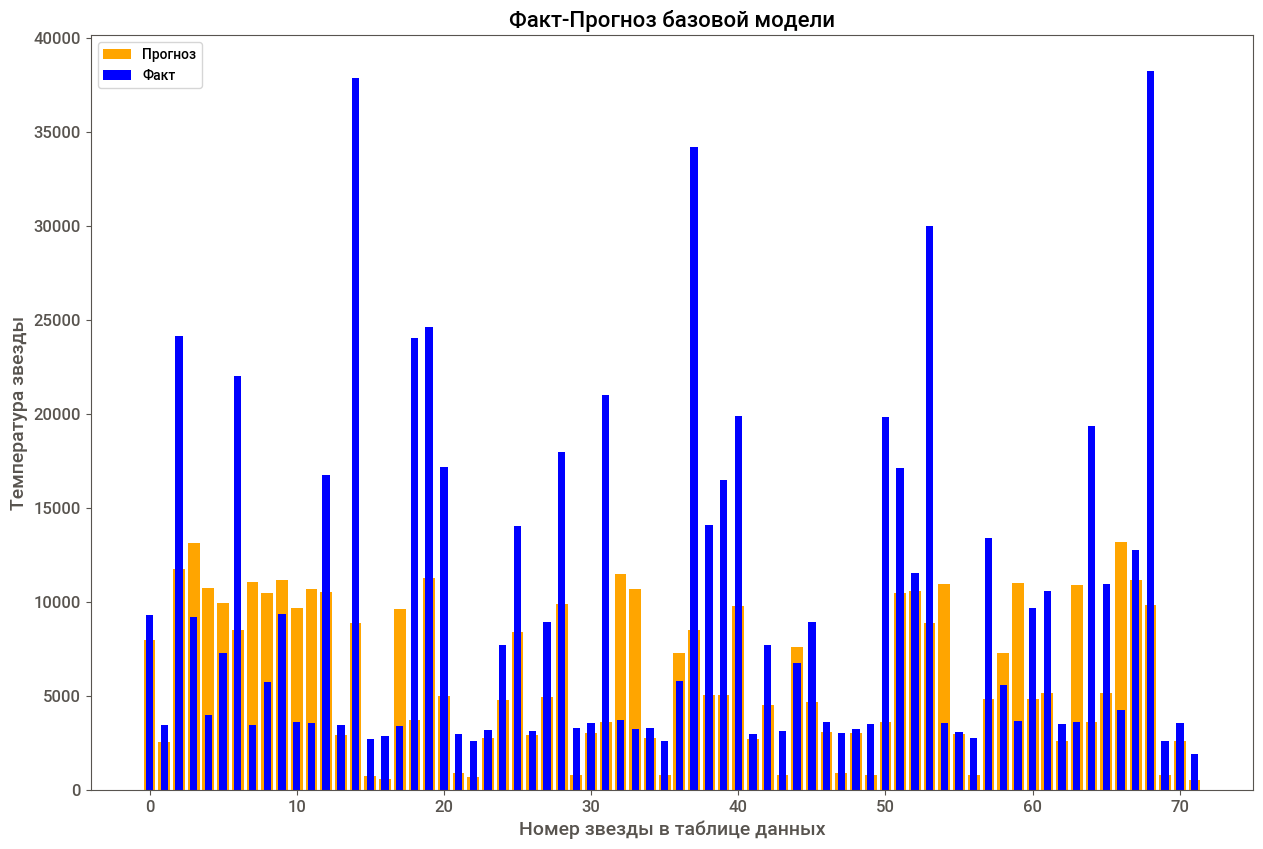

In [37]:
basic_df = y_test 
nn_df = test_preds

x = range(len(basic_df))

plt.figure(figsize=(15, 10))
plt.bar(x, nn_df.detach().numpy(), color='orange', label='Прогноз')
plt.bar(x, basic_df, color='blue', width=0.5, label='Факт')

plt.legend()
plt.title('Факт-Прогноз базовой модели', fontsize=16)
plt.xlabel('Номер звезды в таблице данных', fontsize=14)
plt.ylabel('Температура звезды', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Базовая модель недостаточно точно описывают всю тестовую выборку. на Epoch #: 9000 и RMSE = 4589.56.

- В основном модель достаточно точно попадает в значение температур звезд.
- Есть звезды с сильными отклонениями предсказанной температуры от фактической как в бОльшую сторону, так и в меньшую

Такое расхождение можно объяснить тремя причинами:

- Недостаточным обучением нейронной сети;
- Ограниченным объёмом исходных данных;
- Особенностями или неточностями в признаках определённых звёзд.

Для улучшения работы моделей можно выполнить следующие шаги:

- Использовать батчи
- Регуляризацию (dropout и batch normalization)
- Изменить архитектуру сети
- Провести аугментацию данных, сгенерировать новые

**Вывод по разделу**

Для предсказаний выбрана полносвязаная модель с одним скрытым слоем. Три линейных слоя, с функциями активации `LeakyReLU`. На входе количество нейронов соответствует количеству входных признаков. Скрытый слой имеет 8 нейронов на входе и 5 на выходе.

<a id='Step4'></a>
## 4 Улучшение нейронной сети

- Улучшим модель использованием перебора параметра батчами
- Список параметров для перебора будет включать «dropout» и «размер батча». 
- Архитектуру нейронной сети: количество слоёв, нейронов, вид функции активации — оставим как в Baseline, чтобы сравнить результат.

In [38]:
batch_size = 1
# Создаем Dataset и DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [39]:
class NetImprovement(nn.Module):
    def __init__(self, n_in, n_hidden_1, n_hidden_2, n_out, p_dropout):
        super(NetImprovement, self).__init__()
        self.fc1 = nn.Linear(n_in, n_hidden_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_1)
        self.act1 = nn.LeakyReLU()
        self.dp2 = nn.Dropout(p=p_dropout)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_2)
        self.act2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(n_hidden_2, n_out)
        self.act3 = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dp2(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        return x

In [ ]:
%%time
# Таблица для учета результатов моделей
df = pd.DataFrame(columns=['batch_size', 'p_dropout', 'rmse', 'prediction'])
best_rmse = float('inf')  # Переменная для хранения лучшего RMSE

# Гиперпараметры для перебора
batch_size_list = [60, 40, 20]
p_dropout_list = [0.7, 0.65, 0.6, 0.5]
num_epochs = 5001

# Инициализация сети один раз перед циклами
input_size = X_train.shape[1]
hidden1_size = 8
hidden2_size = 5
output_size = 1

for batch_size in batch_size_list:
    for p_dropout in p_dropout_list:
        # Инициализация сети и оптимизатора
        net = NetImprovement(input_size, hidden1_size, hidden2_size, output_size, p_dropout)
        net.apply(init_weights)
        optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
        loss_fn = nn.MSELoss()
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        for epoch in range(1, num_epochs + 1):
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                preds = net(X_batch).flatten()
                loss = loss_fn(preds, y_batch)
                loss.backward()
                optimizer.step()
            
            # Логирование и валидация (сохранено как в исходном коде)
            if epoch % 1000 == 0:
                net.eval()
                with torch.no_grad():
                    test_preds_2 = net(X_test).flatten()
                    current_rmse = torch.sqrt(loss_fn(test_preds_2, y_test)).item()
                    print(f'Epoch {epoch:04d} | batch_size={batch_size} | p_dropout={p_dropout} | RMSE = {current_rmse:.1f}')
                    
                    # Добавлено: сохранение лучшего результата
                    if current_rmse < best_rmse:
                        best_rmse = current_rmse
                        df.loc[len(df)] = [batch_size, p_dropout, best_rmse, test_preds_2.numpy()]

Epoch 1000 | batch_size=60 | p_dropout=0.7 | RMSE = 13170.3
Epoch 2000 | batch_size=60 | p_dropout=0.7 | RMSE = 8154.5


In [ ]:
df = df.sort_values('rmse').reset_index(drop=True)
df[['rmse','batch_size','p_dropout']]

In [ ]:
basic_df_2 = y_test
nn_df_2 = df.loc[0, 'prediction']

x_2 = range(len(basic_df_2))

plt.figure(figsize=(15, 10))
plt.bar(x_2, nn_df_2, color='orange', label='Прогноз')
plt.bar(x_2, basic_df_2, color='blue', width=0.5, label='Факт')

plt.legend()
plt.title('Факт-Прогноз Улучшенной сети', fontsize=16)
plt.xlabel('Номер звезды в таблице данных', fontsize=14)
plt.ylabel('Температура звезды', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**Вторая модель лучше описывает всю тестовую выборку.**

Также существуют сильные расхождения в предсказаниях и фактических температурах по звездам  в обе стороны. 

Есть куда улучшать модель, но RMSE уже лучше и равно `4231.5` со следующими гиперпараметрами `batch_size=20, p_dropout = 0.6`. 

Использование батчей и Регуляризации (dropout и batch normalization) не дало существенное улучшение метрики RMSE. Вероятная причина - малое количество данных или плохое их качество.

- График базовой сети очень схож с графиком улучшенной сети.
- Существуют у одних и тех же звезд выбросы в предсказаниях - либо слишком большие значения, либо слишком маленькие
- **Температуры звезд с небольшими значениями нейросети предсказывают достаточно точно**

<a id='Step5'></a>
## 5 Выводы

В ходе данного проекта решалась задача с созданием нейросети, которая поможет предсказывать абсолютную температуру на поверхности звезды.

**Предобработка данных:**

- Произвели преобработку данных в категориальных признака - исправили опечатки и откорректировали правильное написание категорий

**Исследовательский анализ:**

Исследовали данные в представленном датасете

- Аномалий и выбросов не обнаружено
- Рассмотрели корреляцию признаков между собой

**Создание базовой нейросети:**

- Создали базовую нейросеть с 1 скрытым слоем, `14 входными нейронами, 8 и 5 на скрытом и 1` на выходном слое
- Лучший результат показала на `Epoch #: 9000 и RMSE = 4589.56689453125 ` 

**Улучшение нейронной сети:**

- Использовали перебор гиперпараметров для размера батча и дропаута
- Использовали Batch Normalization

Лучшей моделью стала нейронная сеть со следующими гиперпараметрами `batch_size=20, p_dropout = 0.6`, у которой среднеквадратическая ошибка равна `RMSE = 4231.5`